## Bitcoin/Cryptocurrency

Cryptocurrencies are digital currencies based on blockchain technology. Their sizes are often measured based on their market capitalization volume, which is calculated as Market Cap = Current Price x Circulating Supply). The three cryptos of interest are among the top 5 in terms of market capitalization - notably, Bitcoin has a market capitalization of about 1.033 Trillion USD, as of March 28, 2021.

***
Buying bitcoin is different than purchasing a stock or bond because there is no financial reports to review or crypto ETF to spread out investment risks (at least, not yet). And unlike fiat currencies, bitcoin is not issued by a central bank or backed by any government, therefore the typical measures such as monetary policy and GDP growth that would impact the value of fiat currencies are not applicable. 

However, it is **not impossible** to predict bitcoin prices. My hypothesis is that the following factors influence the Bitcoin pricing trend:

	1. Supply of bitcoin and the market demand for it
	2. The cost of bitcoin through the mining/creation process
	3. The rewards issued to the miners for verifying transactions to the blockchain
	4. The number and market size of competing cryptocurrencies
	5. The exchanges it trades on
	6. Regulations governing its trade
	7. Its internal security and governance
	8. User adoption
***

I thereby gathered historical, 2020, Bitcoin (BTC) and Ethereum (ETH) prices from Coindesk.com, and three potential price drivers (total number of Bitcoin in the market, total number of confirmed payments, and total hash rate) from Blockchain.com. 

### Data Collection, Wrangling and Exploration

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime
import time
import matplotlib.ticker as mticker
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

BTCrawdata = requests.get('https://production.api.coindesk.com/v2/price/values/BTC?start_date=2020-01-01T00:00&end_date=2021-01-04T12:00&ohlc=false').json()
ETHrawdata = requests.get('https://production.api.coindesk.com/v2/price/values/ETH?start_date=2020-01-01T00:00&end_date=2021-01-04T12:00&ohlc=false').json()

Now we want to take a look at the first ten actual date time and pricing items in the dictionary BTCrawdata['data'] and ETHrawdata['data'] to get an idea of the format -

In [2]:
list(BTCrawdata['data'].items())[:5]

[('iso', 'BTC'),
 ('name', 'Bitcoin'),
 ('slug', 'bitcoin'),
 ('ingestionStart', '2013-10-01'),
 ('interval', '1-day')]

In [3]:
list(ETHrawdata['data'].items())[:5]

[('iso', 'ETH'),
 ('name', 'Ethereum'),
 ('slug', 'ethereum'),
 ('ingestionStart', '2015-08-09'),
 ('interval', '1-day')]

In [4]:
list(BTCrawdata['data'].items())[5][1][:5]

[[1577923199000, 7174.7440119511],
 [1578009599000, 6955.4875796712],
 [1578095999000, 7291.2195053189],
 [1578182399000, 7337.6366701377],
 [1578268799000, 7347.4332644392]]

We now know that the raw BTC data is structured as the daily closing price - going back to as far as Oct 1st, 2013. This is helpful in case we need to expand the study period later. ETH data is only available after Aug 9th, 2015.

Next, I want to introduce the potential drivers of bitcoin values, which includes 3 items: BTC in Circulation per day, the Total Number of Comfirmed Payments per day, and Hash Rate per day. 

BTC in circulation is important because it represents the total bitcoin supply on the network - it is the number of bitcoins that have already been mined. Given the nature of limited supply (21 Million), ceteris paribus, bitcoin's value should be conversely correlated to the amount of un-mined supply. Or conversly, the price should be positively correlated to the supply. 

Secondly, total number of comfirmed BTC payment is defined as the number of recipients receiving funds in a transaction. According to Blockchain.com, "the number of daily confirmed payments highlights the value of the Bitcoin network as a way to securely transfer funds without a third part." Because a single BTC transaction can include multiple payments (to multiple recipients), the number of payments is a good indicator of the general network activity - which I would use as a proxy for market demand.

Lastly, Hash rate is a crucial security metrics that reflects that estimated number of tera hashes per second (trillions of hashes per second) the Bitcoin network is performing. In other words, it measures the combined computer power needed to mine and process transactions on a Proof-of-Work blockchain. Without a central authority to secure and control the supply, bitcoin's value is directly attributed to its security and trustworthiness. As more bitcoins are mined, hash rate increases, and it becomes harder to "break" the blockchain. Thus the network is secured against fraud.

In [5]:
BTCinCirculationRaw = requests.get('https://api.blockchain.info/charts/total-bitcoins?start=2020-01-01T00:00:00').json()
BTCpaymentsRaw = pd.read_json('Crypto/n-payments.json')
BTCHashRateRaw = requests.get('https://api.blockchain.info/charts/hash-rate?start=2020-01-01T00:00:00').json()

In [6]:
BTCinCirculationRaw['values'][:5]

[{'x': 1577836985, 'y': 18133650.0},
 {'x': 1577860942, 'y': 18134087.5},
 {'x': 1577878570, 'y': 18134537.5},
 {'x': 1577893144, 'y': 18134975.0},
 {'x': 1577907501, 'y': 18135412.5}]

In [7]:
BTCpaymentsRaw['values'][:5]

0    {'x': 1522368000, 'y': 386161}
1    {'x': 1522454400, 'y': 270378}
2    {'x': 1522540800, 'y': 263981}
3    {'x': 1522627200, 'y': 315045}
4    {'x': 1522713600, 'y': 360686}
Name: values, dtype: object

In [8]:
BTCHashRateRaw['values'][-5:]

[{'x': 1609027200, 'y': 137358668.73416725},
 {'x': 1609113600, 'y': 147938033.9968089},
 {'x': 1609200000, 'y': 140537799.38571388},
 {'x': 1609286400, 'y': 159029615.0943604},
 {'x': 1609372800, 'y': 153482070.38176647}]

In [9]:
1577923200 - 1577836800

86400

I was able to get the circulating BTC number and the hash rate through API, but I had to download the number of payment as json - so it has a different format and a different starting date. I am going to use merge the three numbers together using the date/time value ("x").

Also, notice that BTC in circulation's datetime are different than those of payments and hash rate, which have intervals of 86400 (representing the number of seconds in a day). BTC in circirlation's data is reported at an irregular interval. Upon a closer look, the total number of mined bitcoins are reported in intervals of 218.75, 225, 437.5 and 450. Based on the notes on Blockchain.com, Bitcoin reward is decreasing as more bitcoins are mined - and the reward is divided by 2 every 210,000 blocks, or approximately four years. That seems to have explained why the reporting interval reduced from 437.5 and 450 to 218.75 and 225, on May 12th, 2020 - because the speed of the mining reward (aka bitcoin creation) is suddenly reduced by half on that day. 

In [10]:
BTCcirc = []
for i in range(len(BTCinCirculationRaw['values'])):
    for x in BTCinCirculationRaw['values'][i].values():
        BTCcirc.append(x)

In [11]:
BTCHR = []
for i in range(len(BTCHashRateRaw['values'])):
    for x in BTCHashRateRaw['values'][i].values():
        BTCHR.append(x)

In [12]:
BTCHR[:10]

[1577836800,
 112718458.532564,
 1577923200,
 96717718.3123778,
 1578009600,
 115924073.721928,
 1578096000,
 115238132.457301,
 1578182400,
 111808426.134167]

In [13]:
BTCpay = []
for i in range(len(BTCpaymentsRaw['values'])):
    for x in BTCpaymentsRaw['values'][i].values():
        BTCpay.append(x)

In [14]:
List1 = []
List2 = []
for i in range(len(BTCcirc)):
    if (i+2) % 2 == 1:
        List2.append(BTCcirc[i])
    else:
        List1.append(BTCcirc[i])

In [15]:
List3 = []
List4 = []
for i in range(len(BTCHR)):
    if (i+2) % 2 == 1:
        List4.append(BTCHR[i])
    else:
        List3.append(BTCHR[i])

In [16]:
List5 = []
List6 = []
for i in range(len(BTCpay)):
    if (i+2) % 2 == 1:
        List6.append(BTCpay[i])
    else:
        List5.append(BTCpay[i])

In order to join the drivers together along with the bitcoin pricing data, I need the BTC in circulation info reportedn in a daily format. 

In [17]:
circrawdatetime = pd.DataFrame(list(zip(List1,List2)), columns =['Date Time', 'Total Number Bitcoin'])

In [18]:
circrawdatetime.head()

,Date Time,Total Number Bitcoin
0,1577836985,18133650.0
1,1577860942,18134087.5
2,1577878570,18134537.5
3,1577893144,18134975.0
4,1577907501,18135412.5


In [19]:
List1new= []
for i in range(len(List1)):
    x = datetime.utcfromtimestamp(List1[i]).strftime('%Y/%m/%d')
    List1new.append(x)

In [20]:
circrawdatetime = pd.DataFrame(list(zip(List1new,List2)), columns =['Date Time', 'Total Number Bitcoin'])

In [21]:
circrawdatetime.head()

,Date Time,Total Number Bitcoin
0,2020/01/01,18133650.0
1,2020/01/01,18134087.5
2,2020/01/01,18134537.5
3,2020/01/01,18134975.0
4,2020/01/01,18135412.5


In [22]:
circrawdatetime = circrawdatetime.drop_duplicates(subset=['Date Time'], keep='last')

In [23]:
List3new= []
for i in range(len(List3)):
    x = datetime.utcfromtimestamp(List3[i]).strftime('%Y/%m/%d')
    List3new.append(x)

In [24]:
List5new= []
for i in range(len(List5)):
    x = datetime.utcfromtimestamp(List5[i]).strftime('%Y/%m/%d')
    List5new.append(x)

In [25]:
driverdf0 = pd.DataFrame(list(zip(List5new,List6)), columns =['Date Time', 'Total Number of Confirmed Payments'])
driverdfhr = pd.DataFrame(list(zip(List3new,List4)), columns =['Date Time', 'Total Hash Rate (TH/s)'])
driverdf0 = driverdf0[driverdf0['Date Time'] >= '2020/01/01'].sort_values(by='Date Time')
merged1 = pd.merge(left=circrawdatetime, right=driverdf0, left_on='Date Time', right_on='Date Time')
merged2 = pd.merge(left=merged1, right=driverdfhr, left_on='Date Time', right_on='Date Time')
merged2

,Date Time,Total Number Bitcoin,Total Number of Confirmed Payments,Total Hash Rate (TH/s)
0,2020/01/01,18135412.50,396386,1.127185e+08
1,2020/01/02,18137162.50,483567,9.671772e+07
2,2020/01/03,18139375.00,503607,1.159241e+08
3,2020/01/04,18141575.00,462587,1.152381e+08
4,2020/01/05,18143775.00,471825,1.118084e+08
...,...,...,...,...
360,2020/12/26,18581768.75,584918,1.271496e+08
361,2020/12/27,18582862.50,643292,1.373587e+08
362,2020/12/28,18583737.50,670402,1.479380e+08
363,2020/12/29,18584837.50,724108,1.405378e+08


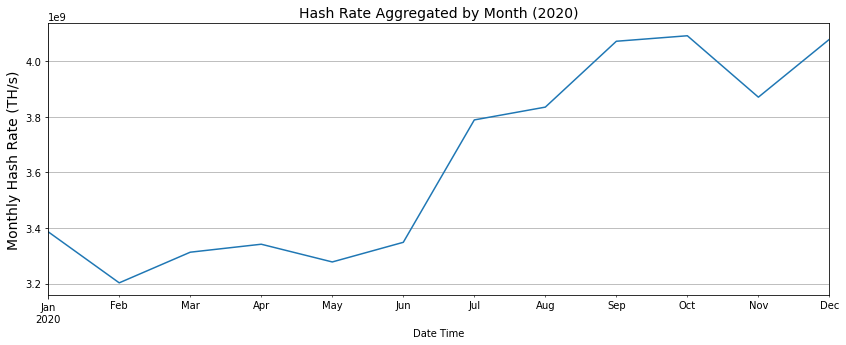

In [26]:
#Plotting average monthly Total Hash Rate (TH/s) profile observed over the entire period 
merged2copy = merged2.copy()
merged2copy['Date Time'] = pd.to_datetime(merged2['Date Time'])
merged2b = merged2copy.set_index('Date Time')
merged2d = merged2b.resample('M')['Total Hash Rate (TH/s)'].sum()
merged2b.resample('M')['Total Hash Rate (TH/s)'].sum().plot(figsize = (14,5))
_ = plt.ylabel('Monthly Hash Rate (TH/s)',fontsize=14)
_ = plt.title('Hash Rate Aggregated by Month (2020)',fontsize=14)
plt.grid(b=None, which='major', axis='both')

In [27]:
merged2

,Date Time,Total Number Bitcoin,Total Number of Confirmed Payments,Total Hash Rate (TH/s)
0,2020/01/01,18135412.50,396386,1.127185e+08
1,2020/01/02,18137162.50,483567,9.671772e+07
2,2020/01/03,18139375.00,503607,1.159241e+08
3,2020/01/04,18141575.00,462587,1.152381e+08
4,2020/01/05,18143775.00,471825,1.118084e+08
...,...,...,...,...
360,2020/12/26,18581768.75,584918,1.271496e+08
361,2020/12/27,18582862.50,643292,1.373587e+08
362,2020/12/28,18583737.50,670402,1.479380e+08
363,2020/12/29,18584837.50,724108,1.405378e+08


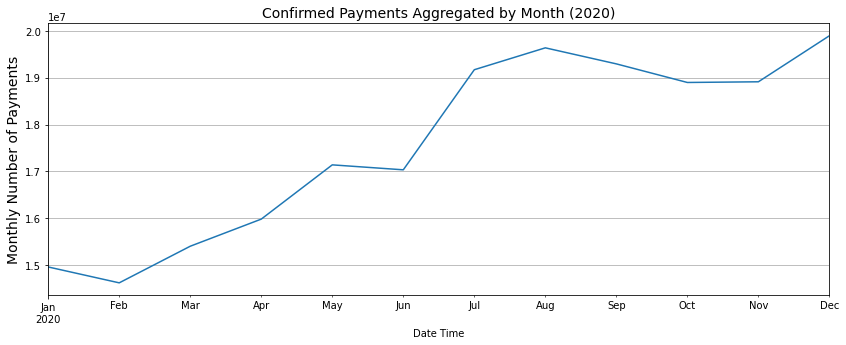

In [28]:
merged2c = merged2b.resample('M')['Total Number of Confirmed Payments'].sum()
merged2b.resample('M')['Total Number of Confirmed Payments'].sum().plot(figsize = (14,5))
_ = plt.ylabel('Monthly Number of Payments',fontsize=14)
_ = plt.title('Confirmed Payments Aggregated by Month (2020)',fontsize=14)
plt.grid(b=None, which='major', axis='both')

In [29]:
'''merged2c = pd.DataFrame(merged2c)
merged2d = pd.DataFrame(merged2d)
merged2e = pd.DataFrame(merged2e)'''

'merged2c = pd.DataFrame(merged2c)\nmerged2d = pd.DataFrame(merged2d)\nmerged2e = pd.DataFrame(merged2e)'

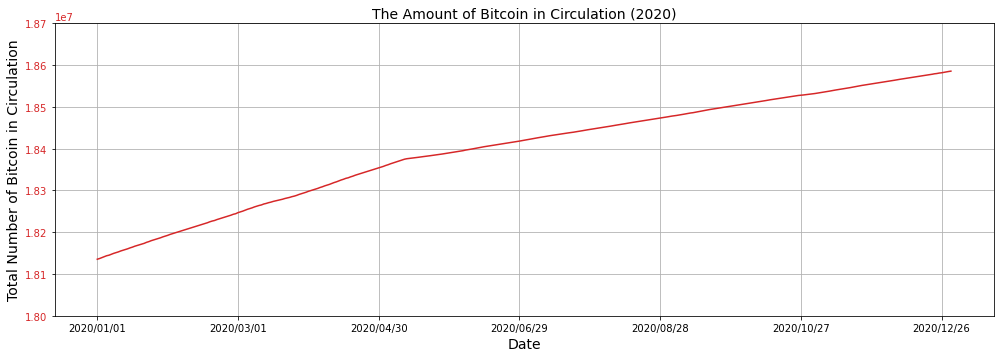

In [30]:
import matplotlib

fig, ax1 = plt.subplots(figsize=(14,5))

color = 'tab:red'
ax1.set_xlabel('Date',fontsize=14)
ax1.set_ylabel('Total Number of Bitcoin in Circulation', fontsize=14)
ax1.plot(merged2['Date Time'], merged2['Total Number Bitcoin'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(18000000, 18700000)

myLocator = mticker.MultipleLocator(60)
ax1.xaxis.set_major_locator(myLocator)
plt.grid(b=None, which='major', axis='both')
fig.tight_layout() 
plt.title('The Amount of Bitcoin in Circulation (2020)',fontsize=14)
plt.show()

Now that we have the 3 potential price drivers organized in a single dataframe, I am going to organize the pricing data in the same fashion.

In [31]:
BTCdf = pd.DataFrame(BTCrawdata['data']['entries'], columns=['Time','BTC Closing Price (USD)'])
BTCdf.shape

(370, 2)

In [32]:
BTCdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Time                     370 non-null    int64  
 1   BTC Closing Price (USD)  370 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.9 KB


In [33]:
df = pd.concat([BTCdf.shift(1), BTCdf], axis=1)
df.columns = ['Time_red','BTC Opening Price (USD)','Time','BTC Closing Price (USD)']
df = df.drop(columns='Time_red',index=0)
BTCdf = df.reindex(columns=['Time','BTC Opening Price (USD)','BTC Closing Price (USD)'])

In [34]:
BTCdf

,Time,BTC Opening Price (USD),BTC Closing Price (USD)
1,1578009599000,7174.744012,6955.487580
2,1578095999000,6955.487580,7291.219505
3,1578182399000,7291.219505,7337.636670
4,1578268799000,7337.636670,7347.433264
5,1578355199000,7347.433264,7713.860754
...,...,...,...
365,1609459199000,28768.836208,29111.521567
366,1609545599000,29111.521567,29333.605121
367,1609631999000,29333.605121,32154.167363
368,1609718399000,32154.167363,33002.536427


In [36]:
BTCdf.describe()

,Time,BTC Opening Price (USD),BTC Closing Price (USD)
count,3.690000e+02,369.000000,369.000000
mean,1.593907e+12,11290.028787,11355.765558
std,9.215887e+09,4654.760341,4766.428506
min,1.578010e+12,4944.702336,4944.702336
25%,1.585958e+12,8904.713817,8905.781605
50%,1.593907e+12,9719.480854,9723.680150
75%,1.601856e+12,11674.624354,11678.373255
max,1.609805e+12,33002.536427,33002.536427


In [37]:
ETHdf = pd.DataFrame(ETHrawdata['data']['entries'], columns=['Time','ETH Closing Price (USD)'])
ethopen_prices = [ETHdf.iloc[0,1]] + ETHdf.iloc[0:369,1].tolist()
ETHdf['ETH Opening Price (USD)'] = ethopen_prices
ETHdf['ETH Opening Price (USD)'] = round(ETHdf['ETH Opening Price (USD)'], 2)
ETHdf['ETH Closing Price (USD)'] = round(ETHdf['ETH Closing Price (USD)'], 2)
ETHdf = ETHdf.drop(labels=0, axis=0)
ETHdf.head()

,Time,ETH Closing Price (USD),ETH Opening Price (USD)
1,1578009599000,127.06,129.89
2,1578095999000,132.97,127.06
3,1578182399000,133.82,132.97
4,1578268799000,134.83,133.82
5,1578355199000,143.13,134.83


In [38]:
jointdf = BTCdf.join(ETHdf.set_index('Time'), on='Time', how='inner')
jointdf.head()

,Time,BTC Opening Price (USD),BTC Closing Price (USD),ETH Closing Price (USD),ETH Opening Price (USD)
1,1578009599000,7174.744012,6955.487580,127.06,129.89
2,1578095999000,6955.487580,7291.219505,132.97,127.06
3,1578182399000,7291.219505,7337.636670,133.82,132.97
4,1578268799000,7337.636670,7347.433264,134.83,133.82
5,1578355199000,7347.433264,7713.860754,143.13,134.83


In [39]:
jointdf.shape

(369, 5)

In [40]:
n_units_in_a_day = BTCdf.loc[2,'Time'] - BTCdf.loc[1,'Time']
n_units_in_a_sec = n_units_in_a_day/24/60/60
print(n_units_in_a_sec)
BTCdf['Time'] = BTCdf['Time']/n_units_in_a_sec
BTCdf['Time'].head()

1000.0


1    1.578010e+09
2    1.578096e+09
3    1.578182e+09
4    1.578269e+09
5    1.578355e+09
Name: Time, dtype: float64

In [41]:
a = int(BTCdf.loc[1,'Time'])
c = datetime.utcfromtimestamp(a).strftime('%Y/%m/%d %H:%M:%S')
e = datetime.strptime(c,"%Y/%m/%d %H:%M:%S")
d = '2020/01/02 00:00:00'
b = datetime.strptime(d,"%Y/%m/%d %H:%M:%S")
timedelta = b-e
add = timedelta.total_seconds()

In [42]:
BTCdf['Time'] = BTCdf['Time'] + add
ETHdf['Time'] = ETHdf['Time']/n_units_in_a_sec + add
jointdf['Time'] = jointdf['Time']/n_units_in_a_sec + add
datetime.utcfromtimestamp(BTCdf['Time'][1]).strftime('%Y/%m/%d')
datetime.utcfromtimestamp(ETHdf['Time'][1]).strftime('%Y/%m/%d')
datetime.utcfromtimestamp(jointdf['Time'][1]).strftime('%Y/%m/%d')

'2020/01/02'

In [43]:
time = []
for i in range(1,370):
    time_i = datetime.utcfromtimestamp(BTCdf.loc[i,'Time']).strftime('%Y/%m/%d')
    time.append(time_i)

In [44]:
len(time)

369

In [45]:
ETHdf.shape

(369, 3)

In [46]:
BTCdf['Date Time'] = time
ETHdf['Date Time'] = time
jointdf['Date Time'] = time
BTCdf.head()

,Time,BTC Opening Price (USD),BTC Closing Price (USD),Date Time
1,1.577923e+09,7174.744012,6955.487580,2020/01/02
2,1.578010e+09,6955.487580,7291.219505,2020/01/03
3,1.578096e+09,7291.219505,7337.636670,2020/01/04
4,1.578182e+09,7337.636670,7347.433264,2020/01/05
5,1.578269e+09,7347.433264,7713.860754,2020/01/06


In [47]:
BTCdf.drop(['Time'], axis=1)
set_BTC_dates = BTCdf.reset_index()
set_BTC_dates = set_BTC_dates[['Date Time','BTC Opening Price (USD)', 'BTC Closing Price (USD)']]
set_BTC_dates.head()

ETHdf.drop(['Time'], axis=1)
set_ETH_dates = ETHdf.reset_index()
set_ETH_dates = set_ETH_dates[['Date Time','ETH Opening Price (USD)', 'ETH Closing Price (USD)']]
set_ETH_dates.head()

jointdf.drop(['Time'], axis=1)
set_joint_dates = jointdf.reset_index()
set_joint_dates = set_joint_dates[['Date Time','BTC Opening Price (USD)', 'BTC Closing Price (USD)','ETH Opening Price (USD)', 'ETH Closing Price (USD)']]
set_joint_dates.head()

,Date Time,BTC Opening Price (USD),BTC Closing Price (USD),ETH Opening Price (USD),ETH Closing Price (USD)
0,2020/01/02,7174.744012,6955.487580,129.89,127.06
1,2020/01/03,6955.487580,7291.219505,127.06,132.97
2,2020/01/04,7291.219505,7337.636670,132.97,133.82
3,2020/01/05,7337.636670,7347.433264,133.82,134.83
4,2020/01/06,7347.433264,7713.860754,134.83,143.13


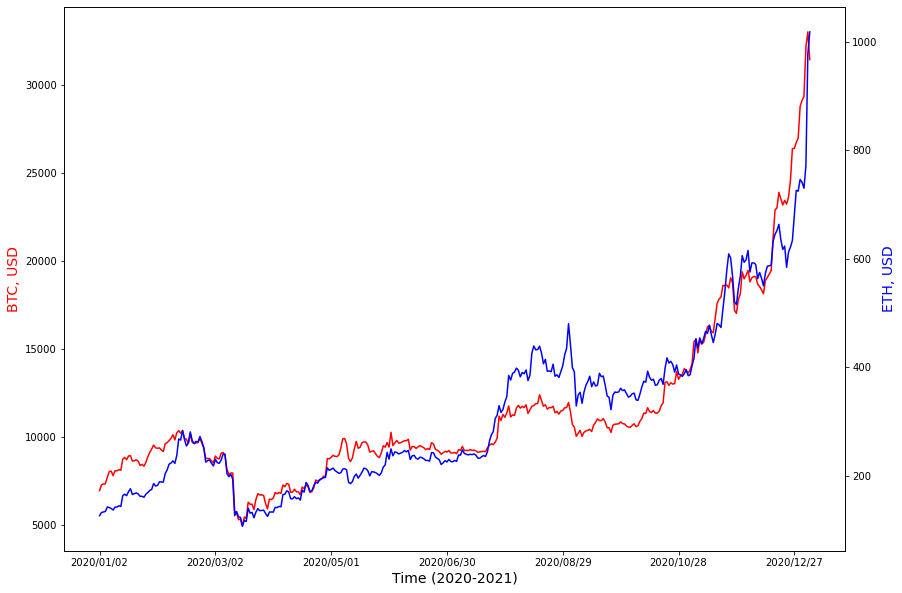

In [48]:
fig,ax = plt.subplots(figsize=(14, 10))
ax.plot(set_joint_dates['Date Time'], set_joint_dates['BTC Closing Price (USD)'], color="red")
ax.set_xlabel("Time (2020-2021)",fontsize=14)
ax.set_ylabel("BTC, USD",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot(set_joint_dates['Date Time'], set_joint_dates['ETH Closing Price (USD)'], color="blue")
ax2.set_ylabel("ETH, USD",color="blue",fontsize=14)

myLocator = mticker.MultipleLocator(60)
ax.xaxis.set_major_locator(myLocator)
plt.show()

## Statistics

            BTC Opening Price (USD)  BTC Closing Price (USD)  \
Date Time                                                      
2020/01/02                      NaN                      NaN   
2020/01/03                -0.030559                 0.048269   
2020/01/04                 0.048269                 0.006366   
2020/01/05                 0.006366                 0.001335   
2020/01/06                 0.001335                 0.049871   
...                             ...                      ...   
2020/12/31                 0.066471                 0.011912   
2021/01/01                 0.011912                 0.007629   
2021/01/02                 0.007629                 0.096155   
2021/01/03                 0.096155                 0.026384   
2021/01/04                 0.026384                -0.047600   

            ETH Opening Price (USD)  ETH Closing Price (USD)  
Date Time                                                     
2020/01/02                      NaN      

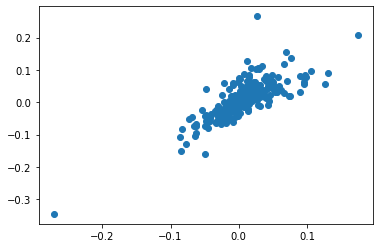

In [49]:
joint1 = set_joint_dates.set_index('Date Time')
returns = joint1.pct_change()
print(returns)
correlation = returns['BTC Closing Price (USD)'].corr(returns['ETH Closing Price (USD)'])
print("Correlation of Bitcoin and Ethereum returns: ", correlation)
plt.scatter(x=returns['BTC Closing Price (USD)'], y=returns['ETH Closing Price (USD)'])
plt.show()

In [51]:
# Run the ADF test on the price series and print out the results
results = adfuller(dfeth)
print(results)
# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]) + ', and we cannot reject the null hypothesis that the Bitcoin prices are a random walk.')

(-12.129664169420906, 1.7477221269336357e-22, 1, 366, {'1%': -3.448343869853195, '5%': -2.869469418606909, '10%': -2.570994248260623}, -1114.0943150628027)
The p-value of the test on prices is: 1.7477221269336357e-22, and we cannot reject the null hypothesis that the Bitcoin prices are a random walk.


Now I want to join the BTC drivers with BTC prices

In [52]:
merged3 = pd.merge(left=merged2, right=set_joint_dates, left_on='Date Time', right_on='Date Time')
merged3 = merged3.drop(['BTC Opening Price (USD)','ETH Opening Price (USD)','ETH Closing Price (USD)'], axis=1)
merged3.tail(5)

,Date Time,Total Number Bitcoin,Total Number of Confirmed Payments,Total Hash Rate (TH/s),BTC Closing Price (USD)
359,2020/12/26,18581768.75,584918,1.271496e+08,26381.296233
360,2020/12/27,18582862.50,643292,1.373587e+08,26389.290265
361,2020/12/28,18583737.50,670402,1.479380e+08,26718.029463
362,2020/12/29,18584837.50,724108,1.405378e+08,26975.729565
363,2020/12/30,18585725.00,762791,1.590296e+08,28768.836208


In [53]:
merged3.describe()

,Total Number Bitcoin,Total Number of Confirmed Payments,Total Hash Rate (TH/s),BTC Closing Price (USD)
count,3.640000e+02,364.000000,3.640000e+02,364.000000
mean,1.839997e+07,578422.826923,1.194787e+08,11085.835297
std,1.251466e+05,80502.498194,1.578010e+07,4196.071254
min,1.813716e+07,390047.000000,7.570223e+07,4944.702336
25%,1.830102e+07,517825.250000,1.089694e+08,8900.411836
50%,1.842073e+07,578192.000000,1.187136e+08,9704.993166
75%,1.850466e+07,641682.750000,1.300063e+08,11666.261306
max,1.858572e+07,793177.000000,1.622631e+08,28768.836208


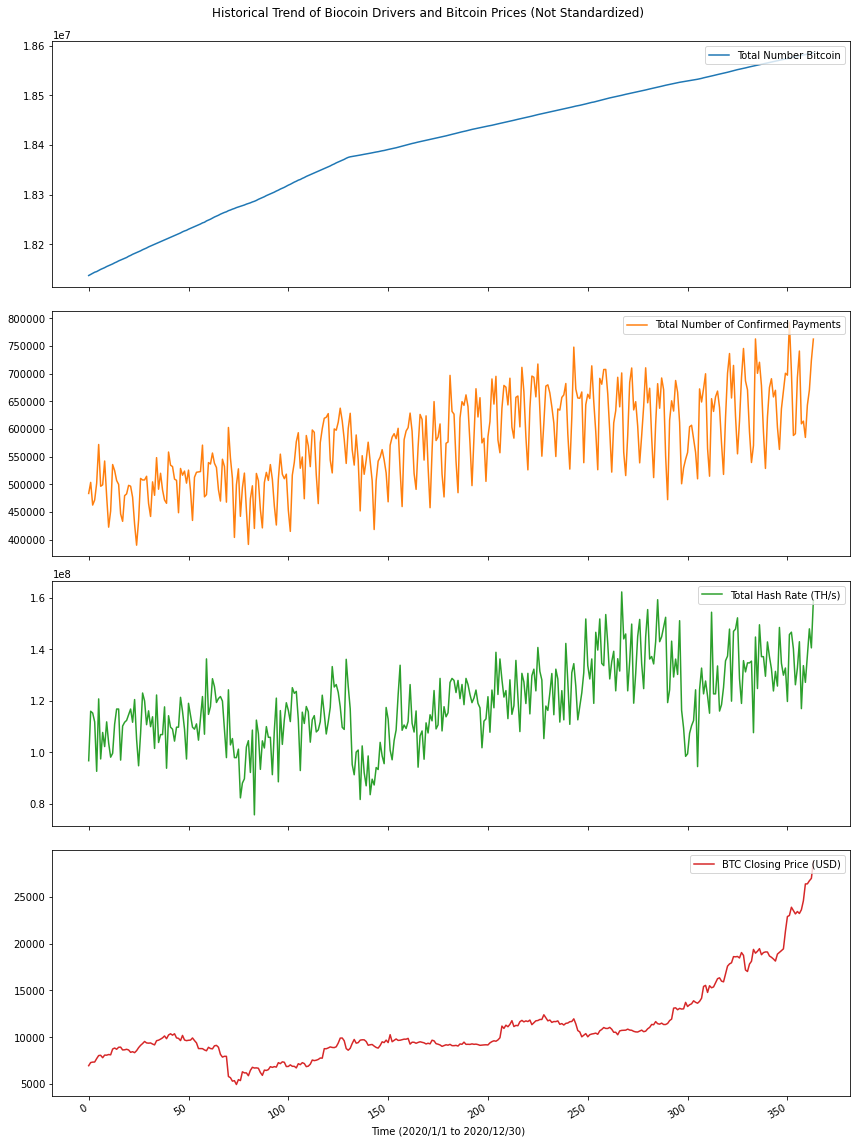

In [54]:
merged3[['Total Number Bitcoin', 'Total Number of Confirmed Payments', 'Total Hash Rate (TH/s)' , 'BTC Closing Price (USD)']].plot(subplots = True, figsize = (12,16))
[ax.legend(loc = 1) for ax in plt.gcf().axes]
plt.text(180, -3.5, 'Time (2020/1/1 to 2020/12/30)', ha='center', va='center')
#ax.set_xlabel('Time')
#ax.set_ylabel('Standardized Values')
plt.suptitle('Historical Trend of Biocoin Drivers and Bitcoin Prices (Not Standardized)')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)

Now I will normalize the data using Standard Scaler.

In [58]:
from sklearn.preprocessing import StandardScaler
x = ['Total Number Bitcoin','Total Number of Confirmed Payments', 'Total Hash Rate (TH/s)','BTC Closing Price (USD)']
scaler = StandardScaler()

for i in x:
    scaler.fit(merged3[[i]])
    merged3[i] = scaler.transform(merged3[[i]])

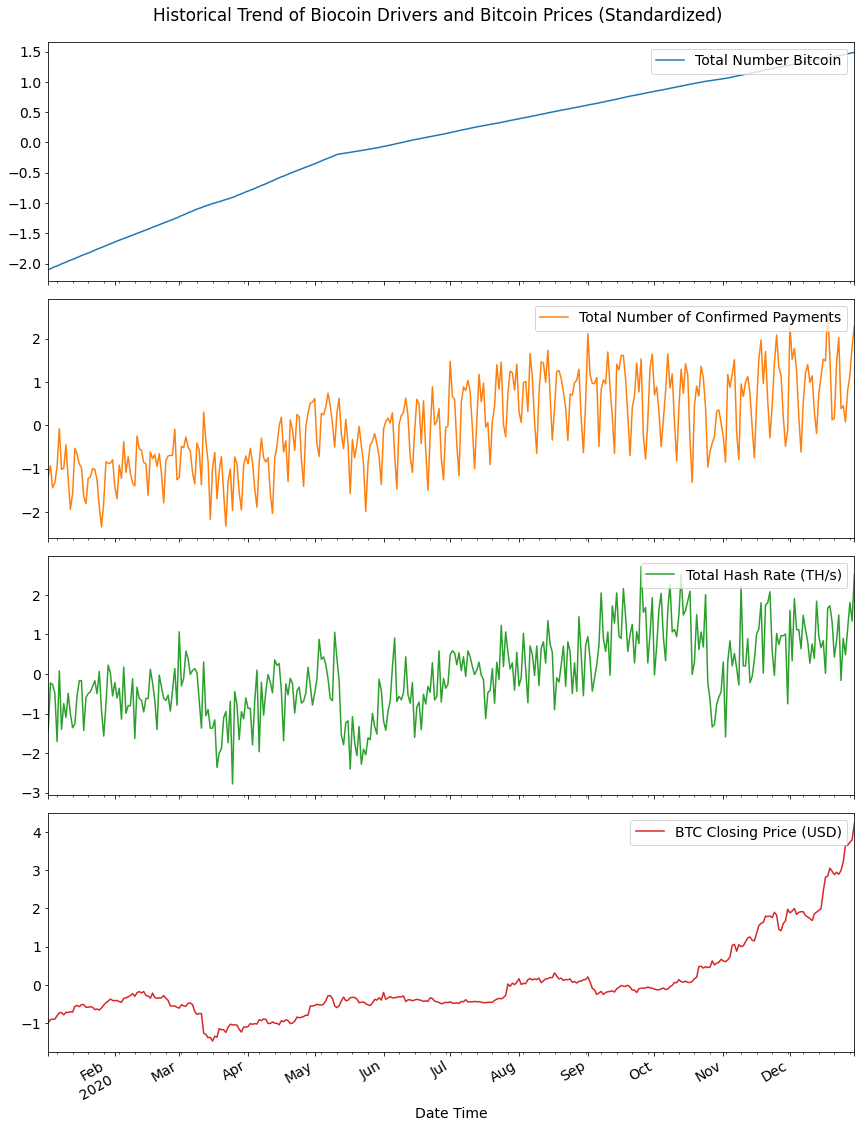

In [59]:
merged3copy = merged3.copy()
merged3copy['Date Time'] = pd.to_datetime(merged3copy['Date Time'])
merged3b = merged3copy.set_index('Date Time')

merged3b[['Total Number Bitcoin', 'Total Number of Confirmed Payments', 'Total Hash Rate (TH/s)' , 'BTC Closing Price (USD)']].plot(subplots = True, figsize = (12,16))
[ax.legend(loc = 1) for ax in plt.gcf().axes]
#plt.text(180, -3.5, 'Time (2020/1/1 to 2020/12/30)', ha='center', va='center')
plt.suptitle('Historical Trend of Biocoin Drivers and Bitcoin Prices (Standardized)')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)

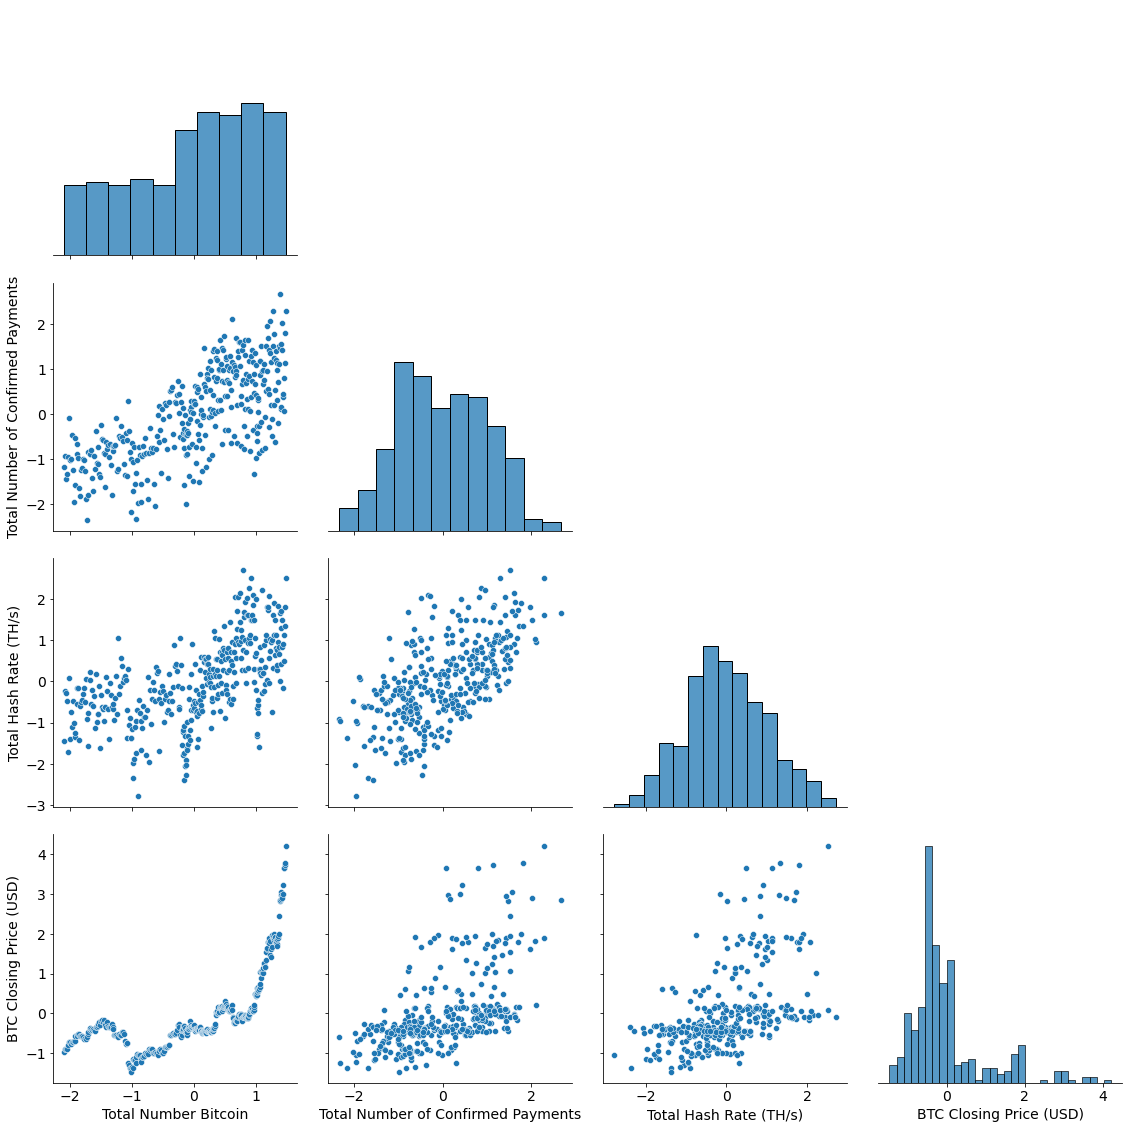

In [60]:
import seaborn as sns
sns.color_palette("cubehelix", as_cmap=True)
_ = sns.pairplot(merged3b,kind="scatter", height=4, corner=True)

There seems to be a pretty decent correlation between the number of bitcoin in circulation and bitcoin price, which is expected because as supply increase, the difficulty of mining increase, and the speed of bitcoin creation slows down. With a relative high market demand, the price of bitcoin went up.

The correlations can be quantified using the **scipy.stats.pearsonr** function. The scipy.stats.pearsonr function returns the pearsonr coefficient and the two-tailed p-value. A signifance level of 5% is selected. If the p-value is lower than 5%, it is unlikely that an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets.

In [65]:
import scipy
scipy.stats.pearsonr(merged3b['BTC Closing Price (USD)'], merged3b['Total Number Bitcoin'])

(0.7048346302087315, 6.156374265184326e-56)

The coefficient is about 0.7, and the p-value is almost 0. I feel confident in saying that the BTC supply has significant impact on its pricing

Calculating the same pearson coefficient for the other two potential drivers. 

In [66]:
scipy.stats.pearsonr(merged3b['BTC Closing Price (USD)'], merged3b['Total Number of Confirmed Payments'])

(0.5415116938844331, 4.02382319888607e-29)

In [67]:
scipy.stats.pearsonr(merged3b['BTC Closing Price (USD)'], merged3b['Total Hash Rate (TH/s)'])

(0.5112737039660739, 1.2368657654509459e-25)

Similarly, the correlations between the pricing and both the demand (payments) and mining difficulty (hash rate) are positive. Given the extremely low p-value, such strong correlation is not a result of random chance.

## Machine Learning

In [50]:
df1 = returns['ETH Closing Price (USD)'].reset_index()
dfeth =  pd.DataFrame(df1.iloc[:,1])
dfeth = dfeth.dropna()
dfeth1 = sm.add_constant(dfeth)
btc = pd.DataFrame(returns['BTC Closing Price (USD)'].reset_index().iloc[:,1]).dropna()
result = sm.OLS(btc.astype(float),dfeth1).fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     BTC Closing Price (USD)   R-squared:                       0.625
Model:                                 OLS   Adj. R-squared:                  0.624
Method:                      Least Squares   F-statistic:                     609.7
Date:                     Sun, 28 Mar 2021   Prob (F-statistic):           6.19e-80
Time:                             20:04:03   Log-Likelihood:                 888.59
No. Observations:                      368   AIC:                            -1773.
Df Residuals:                          366   BIC:                            -1765.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [56]:
from scipy.stats import norm
from io import BytesIO
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

In [57]:
merged3.index.freq="QS-OCT"

# Fit the model
mod = sm.tsa.statespace.SARIMAX(merged3['BTC Closing Price (USD)'], trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

                                  SARIMAX Results                                  
Dep. Variable:     BTC Closing Price (USD)   No. Observations:                  364
Model:                    SARIMAX(1, 1, 1)   Log Likelihood               -2670.964
Date:                     Sun, 28 Mar 2021   AIC                           5349.929
Time:                             20:04:07   BIC                           5365.506
Sample:                                  0   HQIC                          5356.121
                                     - 364                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5183      2.731      0.556      0.578      -3.835       6.871
ar.L1          0.9805      0.036     27.538      0.000       0.911       1.050
ma.L1       